In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import load
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import KFold
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

sns.set_theme(style="whitegrid", font_scale=1.5)

In [64]:
data = pd.read_csv("../data/bias_symptoms_raw_logreg_reduced.csv", index_col=[0,1])
data.index = data.index.droplevel(1)

def evaluate_model(model, X, y):
    """Evaluate the model and return performance metrics."""
    y_pred = model.predict(X)
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    return accuracy, f1, precision, recall

def robustness(xgb_sp, rf_sp, mlp_sp, data, label):
    metrics = pd.DataFrame()
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    thresholds = [0.1, 0.15, 0.2]
    for threshold in thresholds:
        for itrain, itest in kfold.split(data.index.unique().values):
          unbal_data = data.copy()
          unbal_data[label] = data[label].map(lambda x: 1 if abs(x) >= threshold else 0)
          train_index = unbal_data.index.unique()[itrain]
          test_index = unbal_data.index.unique()[itest]
          print(train_index)
          print(test_index)
          train = unbal_data.loc[train_index]
          test = unbal_data.loc[test_index]
          y_train = train[label]
          X_test = test.drop(columns=['statistical_parity', 'equal_opportunity', 'average_odds'])
          y_test = test[label]
          results = {}
          results['threshold'] = threshold
          results['unbalance_train'] = len(train[train[label] == 0]) / len(train[train[label] == 1])
          results['unbalance_test'] = len(test[test[label] == 0]) / len(test[test[label] == 1])
          # Evaluate each model
          for model, name in zip([xgb_sp, rf_sp, mlp_sp], ['XGB', 'RF', 'MLP']):
              model.fit(train.drop(columns=['statistical_parity', 'equal_opportunity', 'average_odds']), y_train)
              accuracy, f1, precision, recall = evaluate_model(model, X_test, y_test)
              results['model'] = name
              results['accuracy'] = accuracy
              results['f1'] = f1
              results['precision'] = precision
              results['recall'] = recall
              metrics = pd.concat([metrics, pd.DataFrame([results])], ignore_index=True)
    return metrics

## Statistical Parity

In [65]:
mlp_sp = MLPClassifier(alpha=0.0001, hidden_layer_sizes=(50,), learning_rate='constant', learning_rate_init=0.01, max_iter=200)
rf_sp = RandomForestClassifier(max_depth=10, max_features='log2', min_samples_leaf=1, min_samples_split=10, n_estimators=500)
xgb_sp = XGBClassifier(colsample_bytree=0.8, gamma=0.2, learning_rate=0.05, max_depth=6, subsample=0.6)

In [66]:
metrics_sp = robustness(xgb_sp, rf_sp, mlp_sp, data, 'statistical_parity')

Index(['german', 'student', 'adult', 'park', 'wine', 'placement', 'hearth',
       'resyduo', 'us', 'law', 'medical', 'vaccine', 'compas', 'ricci', 'bank',
       'health', 'diabetic', 'crime', 'ibm'],
      dtype='object', name='data')
Index(['arrhythmia', 'drug', 'cmc', 'obesity', 'credit'], dtype='object', name='data')
Index(['arrhythmia', 'student', 'adult', 'park', 'placement', 'hearth', 'drug',
       'us', 'cmc', 'law', 'vaccine', 'compas', 'obesity', 'ricci', 'credit',
       'bank', 'health', 'crime', 'ibm'],
      dtype='object', name='data')
Index(['german', 'wine', 'resyduo', 'medical', 'diabetic'], dtype='object', name='data')
Index(['arrhythmia', 'german', 'wine', 'placement', 'hearth', 'drug',
       'resyduo', 'us', 'cmc', 'medical', 'vaccine', 'obesity', 'ricci',
       'credit', 'bank', 'health', 'diabetic', 'crime', 'ibm'],
      dtype='object', name='data')
Index(['student', 'adult', 'park', 'law', 'compas'], dtype='object', name='data')
Index(['arrhythmia', 'german

In [67]:
metrics_melt_sp = metrics_sp.melt(id_vars=['threshold', 'model'],
                                  value_vars=['accuracy', 'f1', 'precision', 'recall'],
                                  var_name='metric', value_name='value')

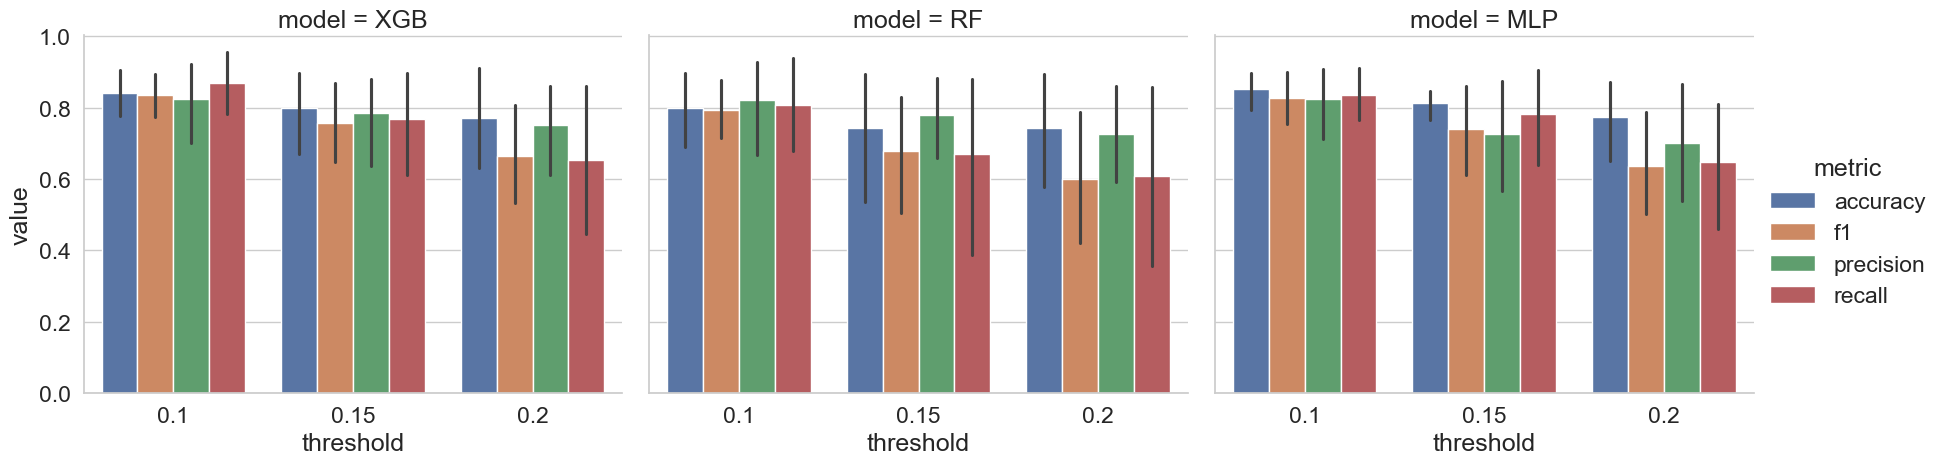

In [68]:
g = sns.catplot(
    data=metrics_melt_sp,
    x='threshold',
    y='value',
    hue='metric',
    col='model',
    kind='bar',
    height=5,
    aspect=1.2,
    sharey=True,
    col_wrap=3
)

## Equal Opportunity

In [69]:
mlp_sp = MLPClassifier(alpha=0.0001, hidden_layer_sizes=(50,), learning_rate='constant', learning_rate_init=0.01, max_iter=200)
rf_sp = RandomForestClassifier(max_depth=10, max_features='log2', min_samples_leaf=1, min_samples_split=10, n_estimators=500)
xgb_sp = XGBClassifier(colsample_bytree=0.8, gamma=0.2, learning_rate=0.05, max_depth=6, subsample=0.6)

In [70]:
metrics_eo = robustness(xgb_sp, rf_sp, mlp_sp, data, 'equal_opportunity')

Index(['german', 'student', 'adult', 'park', 'wine', 'placement', 'hearth',
       'resyduo', 'us', 'law', 'medical', 'vaccine', 'compas', 'ricci', 'bank',
       'health', 'diabetic', 'crime', 'ibm'],
      dtype='object', name='data')
Index(['arrhythmia', 'drug', 'cmc', 'obesity', 'credit'], dtype='object', name='data')
Index(['arrhythmia', 'student', 'adult', 'park', 'placement', 'hearth', 'drug',
       'us', 'cmc', 'law', 'vaccine', 'compas', 'obesity', 'ricci', 'credit',
       'bank', 'health', 'crime', 'ibm'],
      dtype='object', name='data')
Index(['german', 'wine', 'resyduo', 'medical', 'diabetic'], dtype='object', name='data')
Index(['arrhythmia', 'german', 'wine', 'placement', 'hearth', 'drug',
       'resyduo', 'us', 'cmc', 'medical', 'vaccine', 'obesity', 'ricci',
       'credit', 'bank', 'health', 'diabetic', 'crime', 'ibm'],
      dtype='object', name='data')
Index(['student', 'adult', 'park', 'law', 'compas'], dtype='object', name='data')
Index(['arrhythmia', 'german

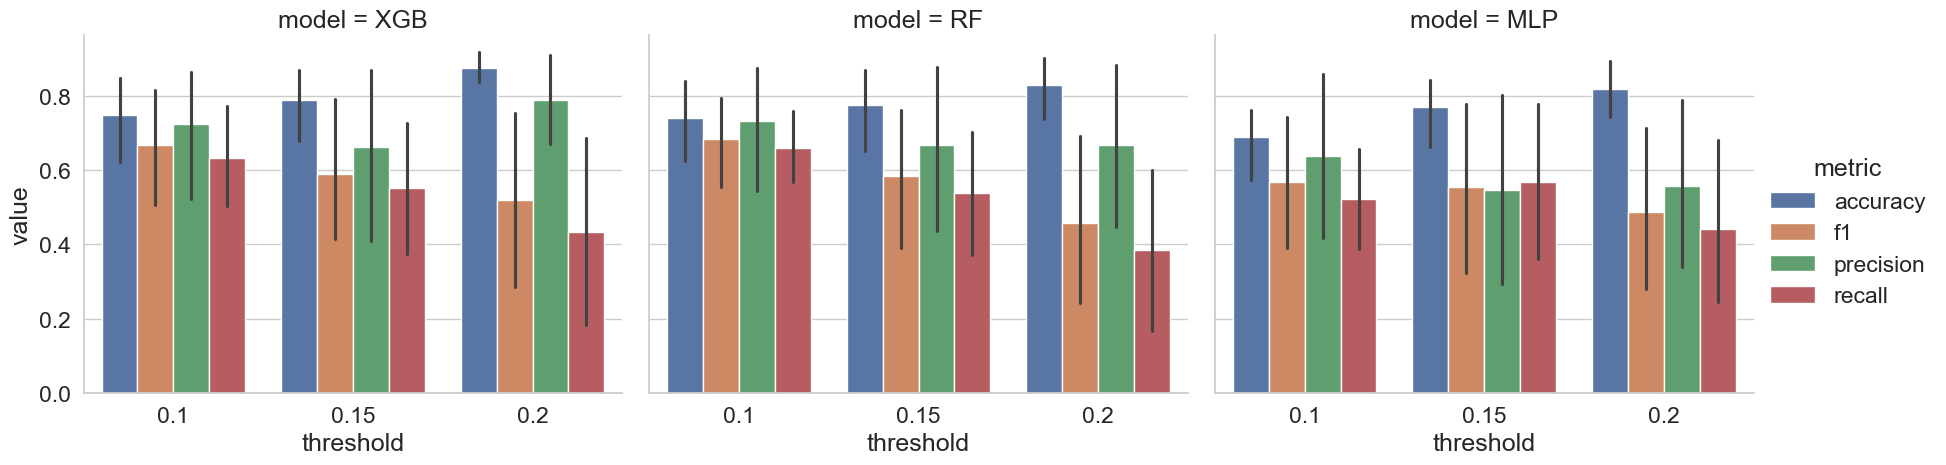

In [71]:
metrics_melt_eo = metrics_eo.melt(id_vars=['threshold', 'model'],
                                  value_vars=['accuracy', 'f1', 'precision', 'recall'],
                                  var_name='metric', value_name='value')
g = sns.catplot(
    data=metrics_melt_eo,
    x='threshold',
    y='value',
    hue='metric',
    col='model',
    kind='bar',
    height=5,
    aspect=1.2,
    sharey=True,
    col_wrap=3
)

## Average Odds

In [72]:
mlp_sp = MLPClassifier(alpha=0.0001, hidden_layer_sizes=(50,), learning_rate='constant', learning_rate_init=0.01, max_iter=200)
rf_sp = RandomForestClassifier(max_depth=10, max_features='log2', min_samples_leaf=1, min_samples_split=10, n_estimators=500)
xgb_sp = XGBClassifier(colsample_bytree=0.8, gamma=0.2, learning_rate=0.05, max_depth=6, subsample=0.6)

In [73]:
metrics_ao = robustness(xgb_sp, rf_sp, mlp_sp, data, 'average_odds')

Index(['german', 'student', 'adult', 'park', 'wine', 'placement', 'hearth',
       'resyduo', 'us', 'law', 'medical', 'vaccine', 'compas', 'ricci', 'bank',
       'health', 'diabetic', 'crime', 'ibm'],
      dtype='object', name='data')
Index(['arrhythmia', 'drug', 'cmc', 'obesity', 'credit'], dtype='object', name='data')
Index(['arrhythmia', 'student', 'adult', 'park', 'placement', 'hearth', 'drug',
       'us', 'cmc', 'law', 'vaccine', 'compas', 'obesity', 'ricci', 'credit',
       'bank', 'health', 'crime', 'ibm'],
      dtype='object', name='data')
Index(['german', 'wine', 'resyduo', 'medical', 'diabetic'], dtype='object', name='data')
Index(['arrhythmia', 'german', 'wine', 'placement', 'hearth', 'drug',
       'resyduo', 'us', 'cmc', 'medical', 'vaccine', 'obesity', 'ricci',
       'credit', 'bank', 'health', 'diabetic', 'crime', 'ibm'],
      dtype='object', name='data')
Index(['student', 'adult', 'park', 'law', 'compas'], dtype='object', name='data')
Index(['arrhythmia', 'german

In [74]:
metrics_ao.groupby(['threshold', 'model']).mean()

unbalance_train  unbalance_test  accuracy        f1  \
threshold model                                                        
0.10      MLP           0.745709        2.233896  0.703303  0.627318   
          RF            0.745709        2.233896  0.621228  0.520583   
          XGB           0.745709        2.233896  0.664499  0.579716   
0.15      MLP           1.169295        2.864303  0.716896  0.574409   
          RF            1.169295        2.864303  0.705304  0.551433   
          XGB           1.169295        2.864303  0.708950  0.562379   
0.20      MLP           1.419523        3.499709  0.724604  0.517616   
          RF            1.419523        3.499709  0.754096  0.554798   
          XGB           1.419523        3.499709  0.756304  0.562927   

                 precision    recall  
threshold model                       
0.10      MLP     0.636320  0.659192  
          RF      0.614892  0.551912  
          XGB     0.618896  0.603959  
0.15      MLP     0.604983  0.578781  
          RF      0.615104  0.543393  
          XGB     0.612189  0.556799  
0.20      MLP     0.556537  0.509029  
          RF      0.656668  0.510289  
          XGB     0.649119  0.526731

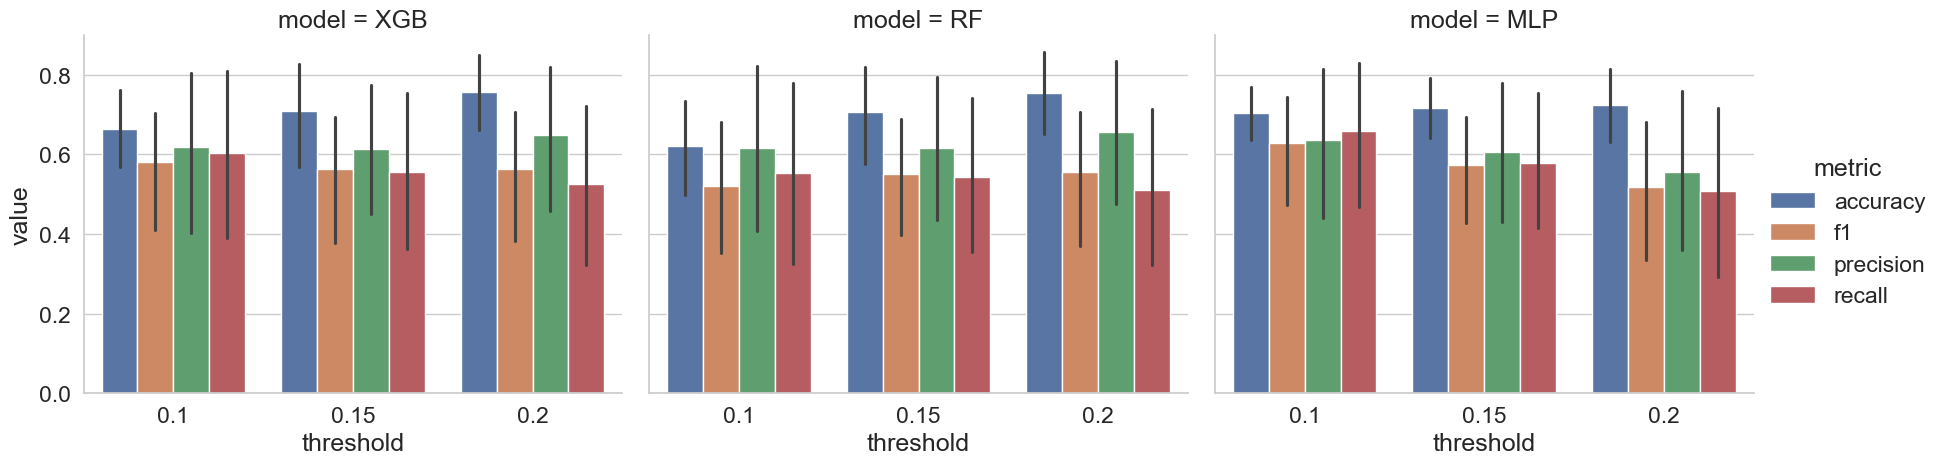

In [75]:
metrics_melt_ao = metrics_ao.melt(id_vars=['threshold', 'model'],
                                  value_vars=['accuracy', 'f1', 'precision', 'recall'],
                                  var_name='metric', value_name='value')
g = sns.catplot(
    data=metrics_melt_ao,
    x='threshold',
    y='value',
    hue='metric',
    col='model',
    kind='bar',
    height=5,
    aspect=1.2,
    sharey=True,
    col_wrap=3
)

## Full results

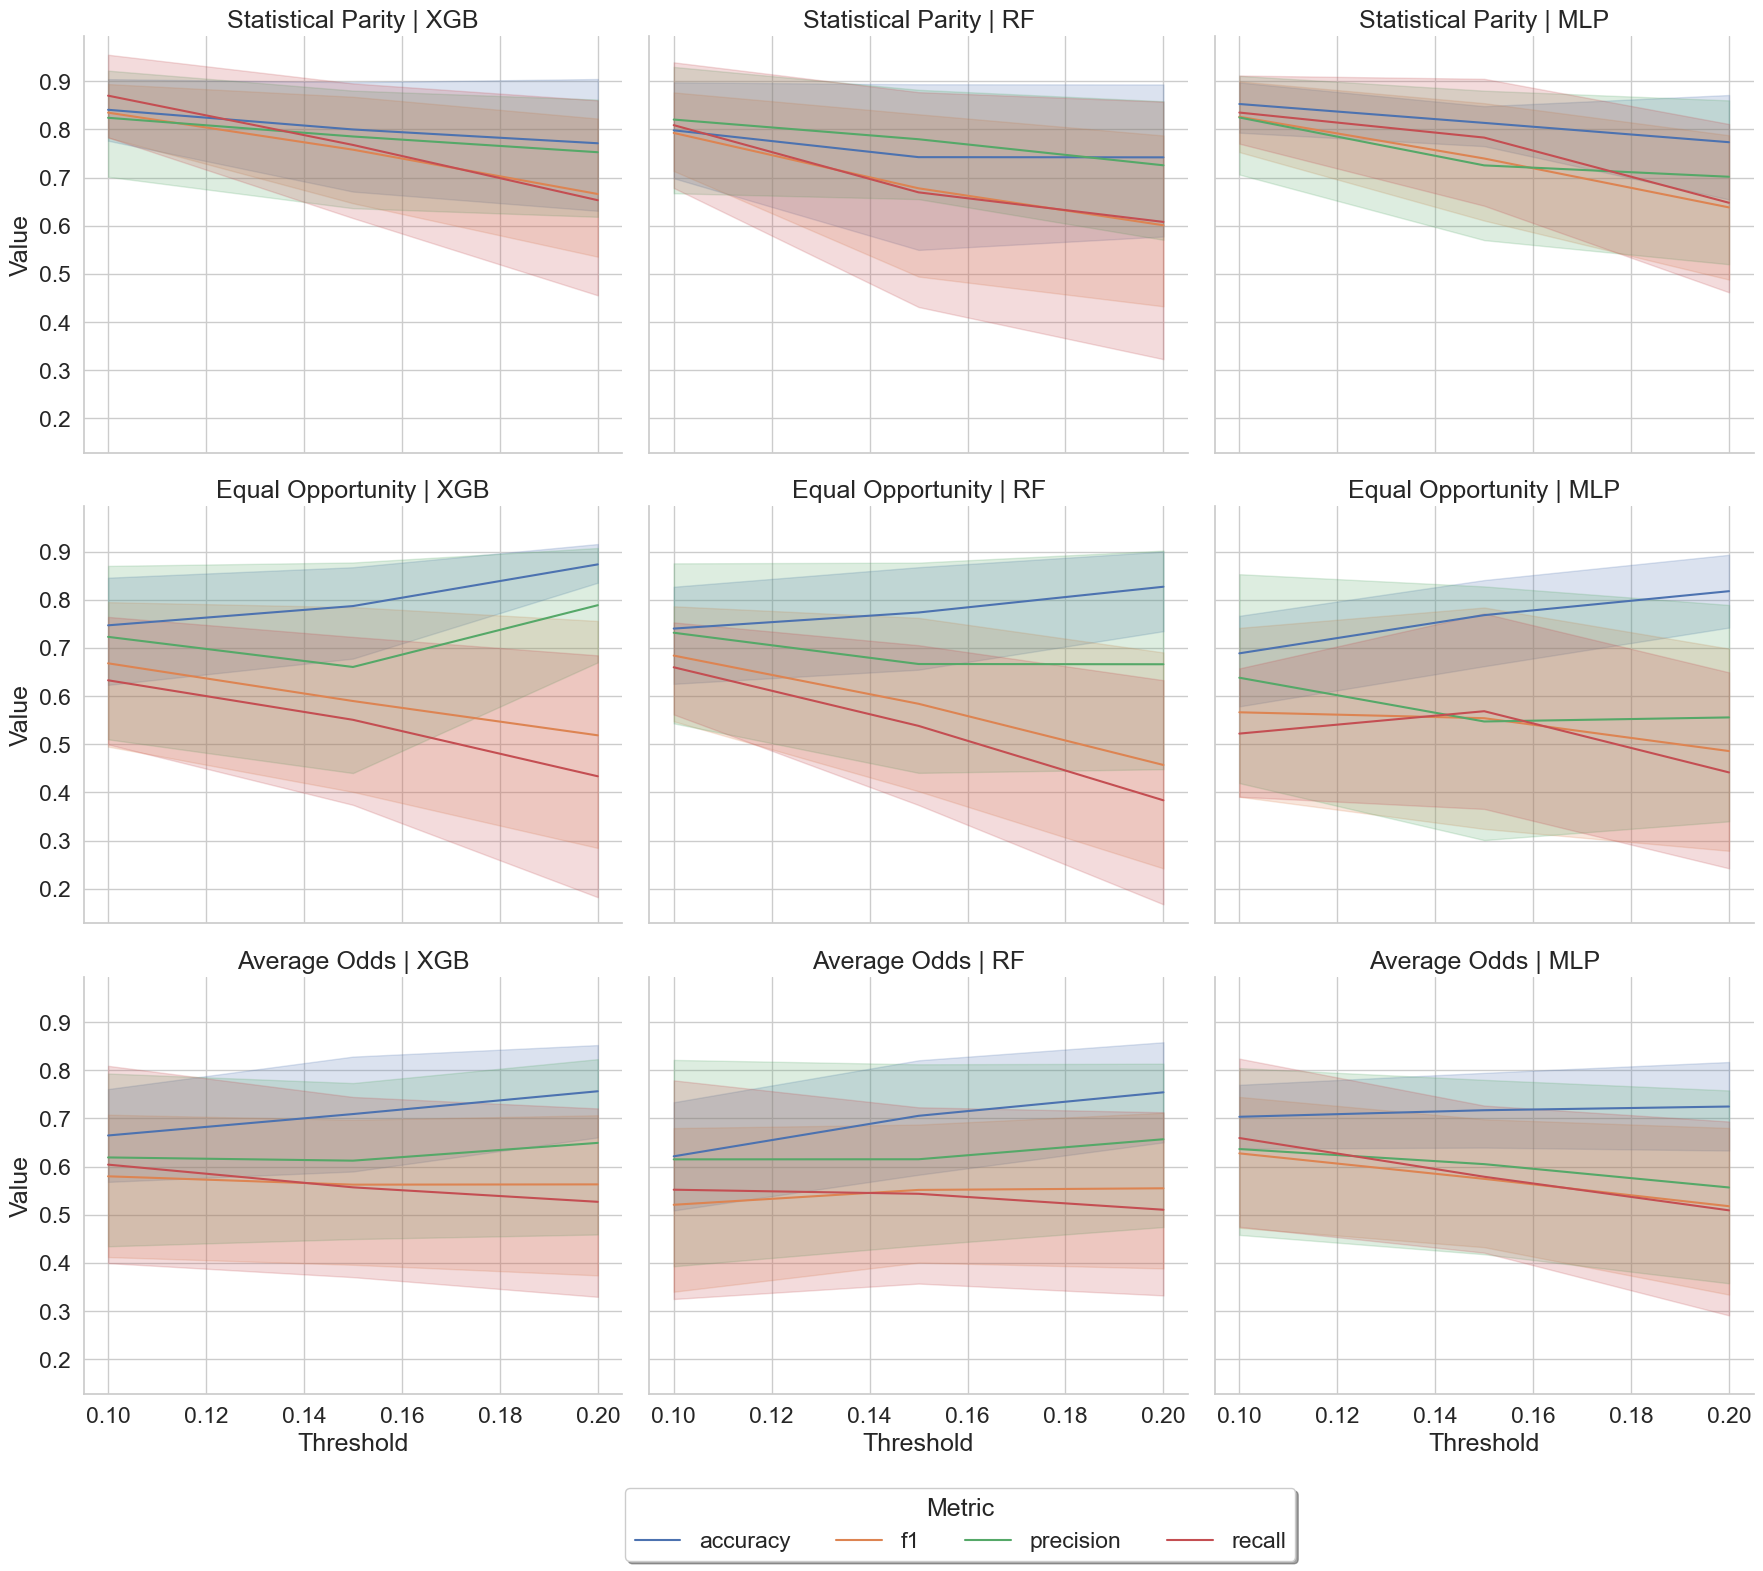

In [82]:
metrics_melt_sp['fairness'] = 'Statistical Parity'
metrics_melt_eo['fairness'] = 'Equal Opportunity'
metrics_melt_ao['fairness'] = 'Average Odds'
metrics_combined = pd.concat([metrics_melt_sp, metrics_melt_eo, metrics_melt_ao], ignore_index=True)

g = sns.relplot(
    data=metrics_combined,
    x='threshold',
    y='value',
    hue='metric',
    col='model',
    row='fairness',
    kind='line',
    height=5,
    aspect=1.2,
    facet_kws={'sharey': True, 'sharex': True},
    markers=True,
    dashes=True
)

# g = sns.catplot(
#     data=metrics_combined,
#     x='threshold',
#     y='value',
#     hue='metric',
#     col='model',
#     row='fairness',
#     kind='bar',
#     height=4,
#     aspect=1.2,
#     sharey=True,
# )


# g.set_xticklabels(metrics_combined['threshold'].unique())

g.set_axis_labels("Threshold", "Value")
g.set_titles(col_template="{col_name}", row_template="{row_name}")
sns.move_legend(g, "lower center", bbox_to_anchor=(0.5, -0.06), ncol=4, title="Metric", frameon=True, shadow=True)
plt.savefig('imbalance.pdf', bbox_inches='tight')